# Histopathologic Cancer Detection
(https://github.com/DSwing/Histopathologic-Cancer-Detection/tree/main)

**Description:** Identify metastatic tissue in histopathologic scans of lymph node sections.

## Introduction

The dataset contains a large number of small pathology images to classify. Files are named with an image id. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. The objective of this project is exploring the CNNs for image classification using Keras library

## Setup

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Cropping2D, Conv2D, Activation, MaxPooling2D, Dense, Dropout, Input, GlobalAveragePooling2D, Normalization, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Load the data

### Raw data download

First, let's download the 6.30G ZIP archive of the raw data:

In [4]:
#!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [01:14<00:00, 109MB/s]
100% 6.31G/6.31G [01:14<00:00, 91.4MB/s]


In [6]:
!unzip -q histopathologic-cancer-detection.zip
!ls

histopathologic-cancer-detection.zip  sample_data	     test   train_labels.csv
kaggle.json			      sample_submission.csv  train


Now we have:

*   a `train` folder which contains all the image for training
*   a sample_submission.csv which contains the labels for all the images in the `train` folder  
*   a `test` folder with the images to be used for prediction


In [ ]:
!ls train | head

00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
000020de2aa6193f4c160e398a8edea95b1da598.tif
00004aab08381d25d315384d646f5ce413ea24b1.tif
0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
0000da768d06b879e5754c43e2298ce48726f722.tif
0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif
00010f78ea8f878117500c445a658e5857f4e304.tif
00011545a495817817c6943583b294c900a137b8.tif
000126ec42770c7568204e2f6e07eb9a07d5e121.tif
00014e39b5df5f80df56f18a0a049d1cc6de430a.tif


### Generate the Datasets and preprocessing

In [7]:
train_dir = "train"
test_dir = "test"
labels_file = "train_labels.csv"

train_labels = pd.read_csv(labels_file)

train_labels['id'] = [x+'.tif' for x in train_labels['id']]
train_labels['label'] = train_labels['label'].astype(str)


test_list = os.listdir(test_dir)
test_df = pd.DataFrame(test_list, columns=['id'])

The function crop_image() is created to crop images to a central 32x32 pixel region, ensuring that we focus on the important central area of the images.

Next, an ImageDataGenerator is initialized with a custom preprocessing function to crop the images, rescale the pixel values to the range [0, 1], and reserve 20% of the data for validation using the validation_split argument.

The flow_from_dataframe() method is then used to generate batches of data from the training dataset and split it into training and validation sets. Both the training (train_ds) and validation (val_ds) datasets are generated by referring to the appropriate subset, with shuffle=True for the training set to introduce randomness.

Finally, a test_gen is created to preprocess and normalize test images, with flow_from_dataframe() used to load test images in test_ds for future predictions, with no labels (y_col=None).

In [8]:
batch_size = 64
target_size = (32, 32)

def crop_image(img):
    """Crop the center of the image to a specified size."""
    cropping_size=(32, 32)
    h, w, _ = img.shape
    crop_h, crop_w = cropping_size
    start_x = (w - crop_w) // 2
    start_y = (h - crop_h) // 2
    return img[start_y:start_y + crop_h, start_x:start_x + crop_w]

gen = ImageDataGenerator(
    preprocessing_function=crop_image,
    rescale=1./255,  # Normalize image pixel values
    validation_split=0.2  # Reserve a portion for validation
)

# Initialize generators for train and validation datasets
train_ds = gen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',  # Use this subset for training
    shuffle=True
)

val_ds = gen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col = 'label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',  # Use this subset for validation
    shuffle=False
)

test_gen = ImageDataGenerator(
    preprocessing_function=crop_image,
    rescale=1./255  # Normalize image pixel values
)

test_ds = test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


## Visualize the data

Here are the first 9 images in the training dataset cropped to the central 32x32 pixels.

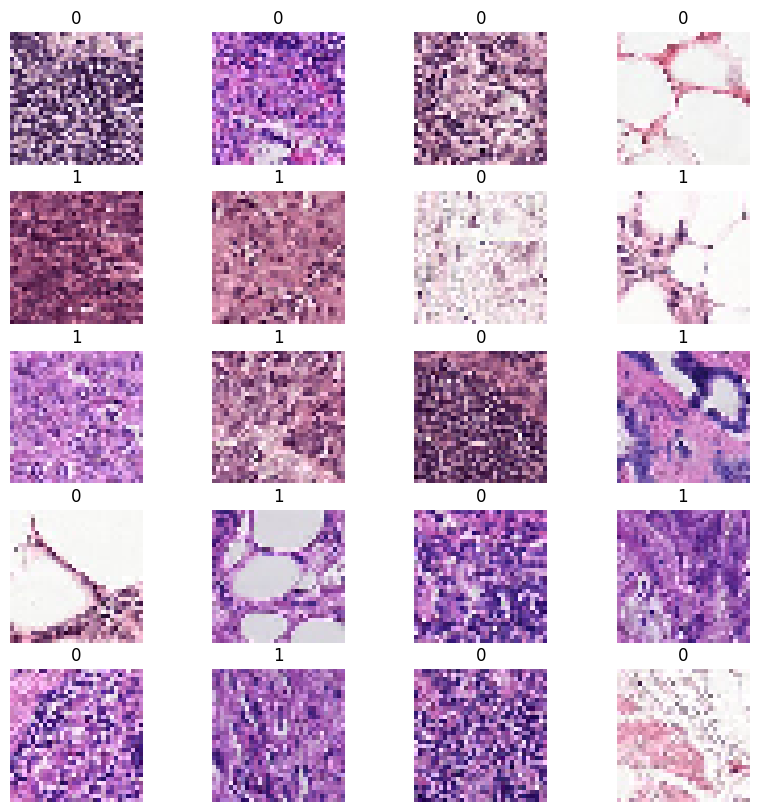

In [ ]:
plt.figure(figsize=(10, 10))
images, labels = train_ds[0]
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(np.array(images[i]))#.astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

## Build a model

We define and compile a first Convolutional Neural Network (CNN) using Keras. The network architecture is structured as follows:

* Input Layer: Accepts images with a shape of 32x32 pixels and 3 color channels.
* Convolutional Layers: Three convolutional layers with 32, 64, and 128 filters, respectively, each followed by ReLU activation and 'same' padding to maintain spatial dimensions.
* MaxPooling Layer: Applies max pooling with a 2x2 window to downsample the feature maps.
* Global Average Pooling: Reduces the spatial dimensions to a single vector, making the model adaptable to various input sizes.
* Fully Connected Layers: Includes two dense layers with 128 and 64 units, respectively, with batch normalization, ReLU activation, and dropout for regularization.
* Output Layer: A single unit with a sigmoid activation function for binary classification.  
The model is compiled with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.

In [ ]:
model = Sequential([
    Input(shape=(32, 32, 3)),  # Allow for variable input sizes
    Conv2D(32, (3, 3), padding = 'same', activation='relu'),
    Conv2D(64, (3, 3), padding = 'same', activation='relu'),
    Conv2D(128, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),  # Allows for different input sizes
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,849 (464.25 KB)

 Trainable params: 118,465 (462.75 KB)

 Non-trainable params: 384 (1.50 KB)

## Train the model

In [15]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

fithistory = model.fit(
    train_ds,
    steps_per_epoch=train_ds.samples//batch_size,
    validation_data=val_ds,
    validation_steps=val_ds.samples//batch_size,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3798s 1s/step - accuracy: 0.8201 - loss: 0.4129 - val_accuracy: 0.7660 - val_loss: 0.5638
Epoch 2/10
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 40:20 881ms/step - accuracy: 0.7969 - loss: 0.4545

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1s 116us/step - accuracy: 0.7969 - loss: 0.4545 - val_accuracy: 0.7838 - val_loss: 0.4668
Epoch 3/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3721s 1s/step - accuracy: 0.8381 - loss: 0.3750 - val_accuracy: 0.7193 - val_loss: 0.6335
Epoch 4/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1s 77us/step - accuracy: 0.8281 - loss: 0.3495 - val_accuracy: 0.7027 - val_loss: 0.8642
Epoch 5/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3747s 1s/step - accuracy: 0.8494 - loss: 0.3494 - val_accuracy: 0.8591 - val_loss: 0.3368
Epoch 6/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 59s 21ms/step - accuracy: 0.7812 - loss: 0.5470 - val_accuracy: 0.8649 - val_loss: 0.3384
Epoch 7/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3777s 1s/step - accuracy: 0.8580 - loss: 0.3327 - val_accuracy: 0.7728 - val_loss: 0.4670
Epoch 8/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 2s 133us/step - accuracy: 0.8438 - loss: 0.3133 - val_accuracy: 0.7838 - val_loss: 0.5227
Epoch 9/10
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3857s 1s/step - accuracy: 0.8656 - loss: 0.319

We get to >85% validation accuracy after training for 10 epochs on the full dataset.

# Accuracy vs epochs  
Plotting the training and validation accuracy over the epochs we see that there is still fluctuaction in accuracy. It would be beneficial to train for longer epochs.

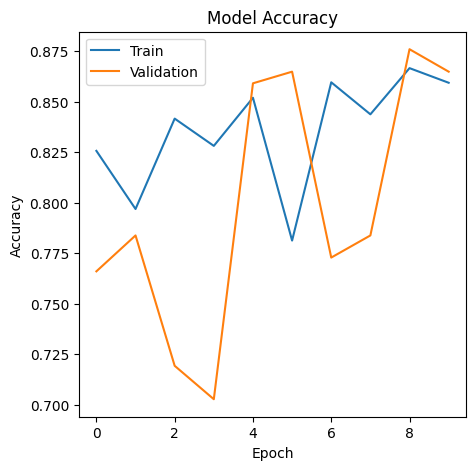

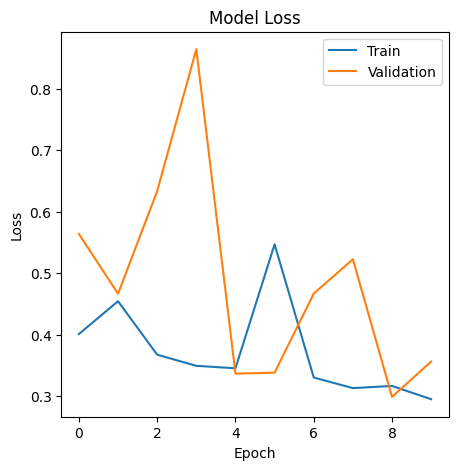

In [19]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

# Displaying results
plt.figure(figsize=(5, 5))
plot_history(fithistory, 'accuracy')
plt.figure(figsize=(5, 5))
plot_history(fithistory, 'loss')

# Second model
We define and compile a second Convolutional Neural Network (CNN) model, model2, which differs from the previous model in a few key ways:

* Input Layer: The input shape is the same, accepting 32x32 images with 3 color channels.
* Convolutional Layers: The model has two convolutional layers with 6 and 12 filters, respectively, making the model smaller and potentially faster to train compared to the previous one.
* MaxPooling and Global Average Pooling: MaxPooling reduces the spatial dimensions, and Global Average Pooling ensures the model can handle variable input sizes.
* Fully Connected Layers: There are two dense layers with 12 and 6 units, respectively, followed by normalization and ReLU activation functions. This setup uses normalization layers to help stabilize the learning process and improve model convergence.
* Output Layer: Similar to the previous model, a single output unit with a sigmoid activation is used for binary classification.  

The model is compiled with the Adam optimizer, binary cross-entropy loss function, and accuracy as the evaluation metric.

In [9]:
model2 = Sequential([
    Input(shape=(32, 32, 3)),  # Allow for variable input sizes
    Conv2D(6, (3, 3), padding = 'same', activation='relu'),
    Conv2D(12, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),  # Allows for different input sizes
    Dense(12),
    Normalization(),
    Activation('relu'),
    Dense(6),
    Normalization(),
    Activation('relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model2.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

fithistory2 = model2.fit(
    train_ds,
    steps_per_epoch=train_ds.samples//batch_size,
    validation_data=val_ds,
    validation_steps=val_ds.samples//batch_size,
    epochs=25,
    callbacks=callbacks
)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 6)           │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 12)          │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 12)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 12)                  │              25 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              78 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 6)                   │              13 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,107 (4.33 KB)

 Trainable params: 1,069 (4.18 KB)

 Non-trainable params: 38 (160.00 B)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2750/2750 ━━━━━━━━━━━━━━━━━━━━ 638s 231ms/step - accuracy: 0.7046 - loss: 0.5746 - val_accuracy: 0.7843 - val_loss: 0.4799
Epoch 2/25
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 5:10 113ms/step - accuracy: 0.7031 - loss: 0.5597

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2750/2750 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 0.7031 - loss: 0.5597 - val_accuracy: 0.7838 - val_loss: 0.4726
Epoch 3/25
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 580s 210ms/step - accuracy: 0.7820 - loss: 0.4792 - val_accuracy: 0.7900 - val_loss: 0.4638
Epoch 4/25
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 2s 622us/step - accuracy: 0.8438 - loss: 0.3987 - val_accuracy: 0.7838 - val_loss: 0.4474
Epoch 5/25
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 591s 200ms/step - accuracy: 0.7873 - loss: 0.4634 - val_accuracy: 0.7949 - val_loss: 0.4608
Epoch 6/25
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.7031 - loss: 0.6130 - val_accuracy: 0.8378 - val_loss: 0.4574
Epoch 7/25
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 567s 206ms/step - accuracy: 0.8067 - loss: 0.4360 - val_accuracy: 0.8221 - val_loss: 0.4135
Epoch 8/25
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.8438 - loss: 0.3543 - val_accuracy: 0.8378 - val_loss: 0.4213
Epoch 9/25
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 541s 194ms/step - accuracy: 0.8148 - los

## Make prediction on new data


We generate predictions using the first model on the test dataset and prepare a submission file.

In [16]:
predictions = model.predict(test_ds)

# Prepare the submission DataFrame
filenames = test_ds.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 363s 401ms/step


In [17]:
!kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "Your message"

100% 2.36M/2.36M [00:00<00:00, 3.37MB/s]
Successfully submitted to Histopathologic Cancer Detection

In [ ]:
Repeating the operation for the second model.

In [10]:
predictions = model2.predict(test_ds)

# Prepare the submission DataFrame
filenames = test_ds.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission2.csv', index=False)

898/898 ━━━━━━━━━━━━━━━━━━━━ 146s 162ms/step


In [11]:
!kaggle competitions submit -c histopathologic-cancer-detection -f submission2.csv -m "Your message"

100% 2.36M/2.36M [00:00<00:00, 12.4MB/s]
Successfully submitted to Histopathologic Cancer Detection

# Results from kaggle competition

In [12]:
!kaggle competitions submissions -c histopathologic-cancer-detection

fileName         date                 description   status    publicScore  privateScore  
---------------  -------------------  ------------  --------  -----------  ------------  
submission2.csv  2024-09-16 21:53:18  Your message  complete  0.8153       0.7377        
submission.csv   2024-09-16 19:18:13  Your message  complete  0.7844       0.7570        


Submission 2 seems to perform better on the public test set but worse on the private test set. This discrepancy might be due to overfitting to certain characteristics of the public dataset.  
Submission 1, while having a lower public score, performs better on the private dataset, indicating more balanced performance and better generalization.
To improve future submissions, it might be worth fine-tuning the model by focusing on regularization techniques.
